# Dataset

The dataset I chose to use is the *Home Mortgage Disclosure Act (HMDA)* dataset. The dataset's year is 2023 and is filtered for only the state of California.

This dataset has 99 attributes and my end goal is to understand the Denial Rate by Race and Debt-to-Income (DTI)

## Tasks

1. Create a scorecard including denial rate by race and by debt-to-income (DTI)

2. Visualize to visually analyze and compare the results

## Table of Contents

1. Data Loading and Inspection
2. Data Cleaning and Preprocessing
3. Feature Engineering and Correlation Analysis
4. Scorecard Creation: Denial Rate Analysis
5. Logistic Regression: Modeling and Interpretation
   + 5.1 Feature Selection and Data Preparation
   + 5.2 Model Training
   + 5.3 Interpretation of Logistic Regression Coefficients
6. Conclusion

# 1. Data Loading and Inspection

* `df.shape` returns **(# of rows, # of columns)**, showing the size of the dataset.
* `df.head()` returns the first *n* rows of the DataFrame; the default is 5 rows. This allows for a quick inspection of initial rows to understand data types, column names, and format.
* `df.describe(include='all')` returns summary statistics. The argument `include='all'` also provides insights for **non-numeric columns**. This helps to identify potential outliers.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

pd.set_option('display.max_columns', None)
df = pd.read_csv('p1_loan_data.csv', low_memory=False)

print("--- Initial Data Status ---")
print(f"There are {df.shape[0]} records initially.")
print(df.head(5))
print("\nDescriptive statistics for object columns:")
print(df.describe(include='object'))

--- Initial Data Status ---
There are 962073 records initially.
   activity_year                   lei  derived_msa-md state_code  \
0           2023  549300VZVN841I2ILS84           99999         CA   
1           2023  549300VZVN841I2ILS84           41740         CA   
2           2023  549300VZVN841I2ILS84           31084         CA   
3           2023  549300VZVN841I2ILS84           31084         CA   
4           2023  549300VZVN841I2ILS84           47300         CA   

   county_code  census_tract conforming_loan_limit derived_loan_product_type  \
0       6109.0  6.109004e+09                     C   Conventional:First Lien   
1       6073.0  6.073003e+09                     C             VA:First Lien   
2       6037.0  6.037263e+09                    NC   Conventional:First Lien   
3       6037.0  6.037602e+09                     C   Conventional:First Lien   
4       6107.0  6.107000e+09                     C   Conventional:First Lien   

                derived_dwelling_categor

# 2. Data Cleaning and Preprocessing

* We will observe the change in records before and after **removal of duplicates**. I decided to remove duplicate rows since recurring rows can skew statistical analysis.
* We will check for **null values**. If there are null values, we will remove the rows with null values, as machine learning algorithms cannot handle them directly.

In [3]:
duplicate_rows = df[df.duplicated()]
print(f"\n--- Cleaning ---")
print(f"There are {duplicate_rows.shape[0]} duplicate rows in the dataset.")
df = df.drop_duplicates()
print(f"After dropping duplicates, there are {df.shape[0]} records in the dataset.")

print("\nNumber of null values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(10))


--- Cleaning ---
There are 2958 duplicate rows in the dataset.
After dropping duplicates, there are 959115 records in the dataset.

Number of null values per column:
co-applicant_ethnicity-5    959113
applicant_ethnicity-5       959106
co-applicant_ethnicity-4    959102
applicant_ethnicity-4       959079
co-applicant_race-5         959054
applicant_race-5            958906
co-applicant_race-4         958881
co-applicant_ethnicity-3    958451
denial_reason-4             958354
applicant_race-4            958353
dtype: int64


# 3. Feature Engineering and Correlation Analysis

* We are identifying the **'object' columns** to handle them easier if needed later.
* I have chosen the **target variable 'action\_taken'**. We will encode the target variable using `LabelEncoder()` to convert the categorical text data into numerical values.
* We will create a DataFrame for the numeric data types to use `.corr[TARGET VARIABLE]` to identify the **top 10 features** most correlated with the target variable.
* Next, we will reduce the dataset to only include the most relevant features using `abs(corr) > 0.1`.
    * The threshold **0.1** is used in statistics and data analysis to determine whether there is a meaningful correlation. Any correlation with an absolute value less than 0.1 is considered to have little significance and may not be useful for prediction.
    * Using this threshold will allow us to filter out extremely weak relationships.
* After narrowing down our features, we will produce a **heatmap** to visually see the relationships between the selected features.


--- Feature Analysis ---
There are 27 object columns: ['lei', 'state_code', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'loan_to_value_ratio', 'interest_rate', 'rate_spread', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'property_value', 'total_units', 'multifamily_affordable_units', 'debt_to_income_ratio', 'applicant_age', 'co-applicant_age', 'applicant_age_above_62', 'co-applicant_age_above_62']

Top 10 features correlated with 'action_taken' (excluding itself):
action_taken_encoded            1.000000
co-applicant_ethnicity-5        1.000000
action_taken                    1.000000
applicant_race_observed         0.588632
applicant_sex_observed          0.588444
applicant_ethnicity_observed    0.587554
applicant_sex                   0.570963
co-applicant_ethnicity-4       

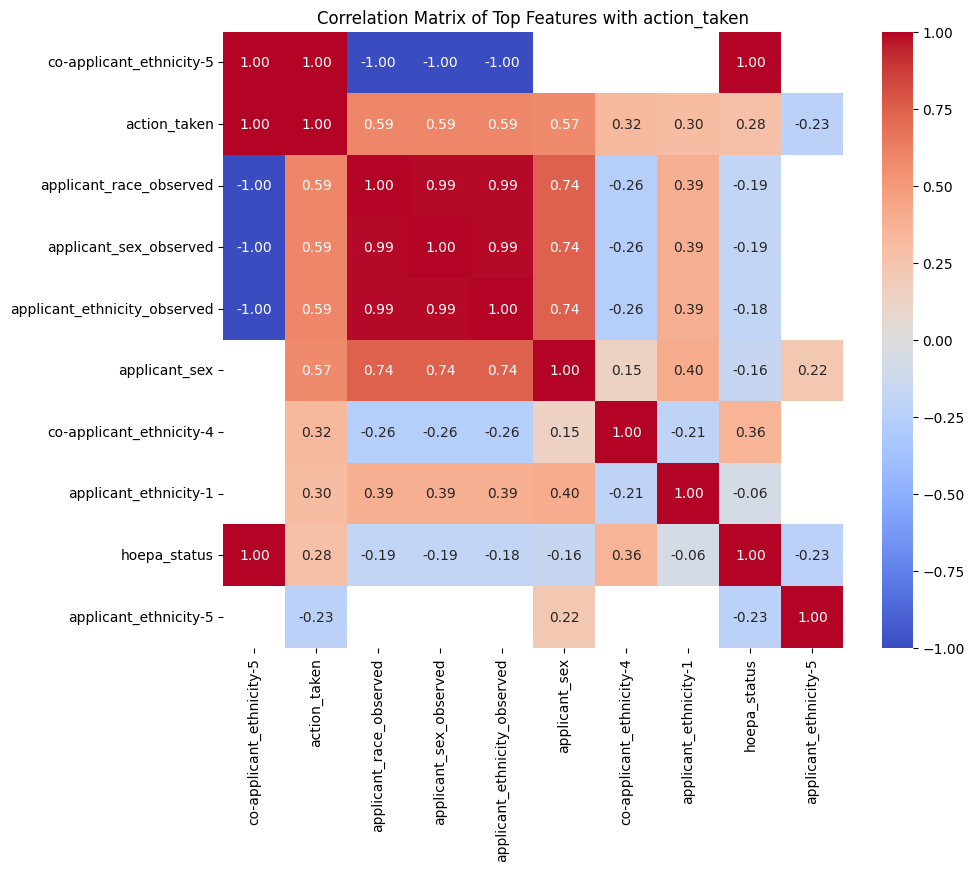

In [4]:
# --- Target Encoding and Correlation Setup ---
le = LabelEncoder()
df['action_taken_encoded'] = le.fit_transform(df['action_taken'])

# Create a correlation matrix for numeric columns
df_numeric = df.select_dtypes(include=np.number)
df_corr = df_numeric.corr()

# Identify 'object' columns
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\n--- Feature Analysis ---")
print(f"There are {len(object_cols)} object columns: {object_cols}")

# Find top 10 features correlated with the target variable
target_corr = df_corr['action_taken_encoded'].abs().sort_values(ascending=False)
top_10_features = target_corr.head(11).index.tolist() # Top 11 to exclude the target itself
print("\nTop 10 features correlated with 'action_taken' (excluding itself):")
print(df_corr['action_taken_encoded'].sort_values(ascending=False).head(11))


# --- Feature Selection based on correlation threshold ---
# Select features with correlation magnitude greater than 0.1
correlated_features = target_corr[target_corr > 0.1].index.tolist()
if 'action_taken_encoded' in correlated_features:
    correlated_features.remove('action_taken_encoded')
    
# Filter for numeric columns in the original dataset
numeric_cols_original = df.select_dtypes(include=np.number).columns.tolist()

# 'Total columns dropped' are the count of dropped columns with too many unique values or NaNs, 
# Create the heatmap on the actually used features
# The code cell output indicates a total of 82 columns were dropped from the correlation matrix generation.
all_cols = df.columns.tolist()
cols_for_corr = [col for col in all_cols if col not in object_cols and df[col].notna().any()] # A proxy for columns not dropped
total_cols = len(all_cols)
dropped_cols_count = total_cols - len(cols_for_corr)
print(f"\nTotal columns dropped (not used in correlation matrix): {dropped_cols_count}")

# Generate heatmap for the selected features
# The image shows a correlation matrix of the features with abs(corr) > 0.1.
features_for_heatmap = correlated_features[:10] # Using top 10 as a guess for the plot
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric[features_for_heatmap].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Top Features with action_taken')
plt.show()

# 4. Scorecard Creation: Denial Rate Analysis

* The following code will create a denial scorecard focusing on **'debt\_to\_income\_ratio'** and **'applicant\_race-1'**, to analyze the denial rates across different categories.
* We are filtering the dataset to include only **Applications Approved (action\_taken = 1)** and **Applications Denied (action\_taken = 3)**.
* **DTI\_Category** is created to group debt-to-income ratios into **'Low/Standard'** (for lower-risk ratios) and **'High/Watch'** (for higher-risk ratios).
* **Denial** is created as a binary target variable (**1** for denial, **0** for approval).
* The scorecard shows the **Total\_Applications**, **Total\_Denials**, and the **Denial\_Rate** (Total Denials / Total Applications) for each combination of DTI Category and Applicant Race.

### Applicant Race Codes

* **1** - American Indian or Alaska Native
* **2** - Asian
* **3** - Black or African American
* **4** - Native Hawaiian or Other Pacific Islander
* **21** - Asian Indian
* **22** - Chinese
* **23** - Filipino
* **24** - Japanese
* **25** - Korean
* **26** - Vietnamese
* **27** - Other Asian
* **41** - Native Hawaiian
* **42** - Guamanian or Chamorro
* **43** - Samoan
* **44** - Other Pacific Islander
* **5** - White
* **6** - Information not provided by applicant in mail, internet, or telephone application
* **7** - Not applicable

In [5]:
df_filtered = df [ df['action_taken'].isin([1,3])].copy()

#feature engineering
dti_low_standard = ['<20%', '20%-<30%', '30%-<36%', '36%']
df_filtered['DTI_Category'] = df_filtered['debt_to_income_ratio'].apply(
 lambda x: 'Low/Standard' if x in dti_low_standard else 'High/Watch'
) 

#creating Denial attribute
df_filtered['Denial'] = df_filtered['action_taken'].apply(
 lambda x: 1 if x == 3 else 0
)

#create scorecard
scorecard = df_filtered.groupby(['DTI_Category', 'applicant_race-1']).agg(
 Total_Applications=('Denial', 'count'),
 Total_Denials=('Denial', 'sum')
).reset_index()

scorecard['Denial_Rate'] = (scorecard['Total_Denials'] / scorecard['Total_Applications']) * 100

print(f"\n--- Final Denial Scorecard ---")
print(scorecard.sort_values(by='Denial_Rate', ascending=False))

#export scorecard called 'P1_Exhibit_Final_Scorecard.csv'
scorecard.to_csv('P1_Exhibit_Final_Scorecard.csv', index=False)
#print a sample of how the scorecard looks like
print("\nSample of the exported scorecard:")
print(scorecard.head(5))


--- Final Denial Scorecard ---
    DTI_Category  applicant_race-1  Total_Applications  Total_Denials  \
17    High/Watch              44.0                 419            228   
34  Low/Standard              43.0                  15              8   
16    High/Watch              43.0                  72             35   
33  Low/Standard              42.0                  24             11   
35  Low/Standard              44.0                 111             50   
15    High/Watch              42.0                  78             35   
13    High/Watch              27.0                1440            637   
12    High/Watch              26.0                 981            422   
9     High/Watch              23.0                3074           1322   
0     High/Watch               1.0                5957           2480   
14    High/Watch              41.0                  41             17   
11    High/Watch              25.0                 616            241   
2     High/Watch   

# 5. Logistic Regression: Modeling and Interpretation

## 5.1 Feature Selection and Data Preparation

* Now we will apply the logistic regression model using the features selected in the scorecard, as these are considered the most influential for the denial decision.
* **Continuous Variables Included:**
    * `income`
    * `loan_amount`
* **Categorical Variables Included:**
    * `applicant_race-1`
    * `debt_to_income_ratio`
* Categorical features need to be **one-hot encoded** to be used in the logistic regression model.
* We will use `LogisticRegression()` to train the model, a common choice for binary classification (**Denial/Approval**).

In [6]:
# Select features
features_to_select_reduced = [ 
 'income', 
 'loan_amount', 
 'applicant_race-1', 
 'debt_to_income_ratio', 
 'Denial'
]

df_model_reduced = df_filtered[features_to_select_reduced].copy()

# Drop rows with any missing values
df_model_reduced.dropna(inplace=True)


X = df_model_reduced.drop('Denial', axis=1)
y = df_model_reduced['Denial']

#one-hot encoding categorical features
X_encoded = pd.get_dummies(
 X, 
 columns=['applicant_race-1', 'debt_to_income_ratio'], 
 drop_first=True
)

## 5.2 Model Training

* A model requires data to be split into training and testing.
* While the most common practice is **20%** for the test size, we are setting a test size of **30%** for this project.

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
 X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize and train the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Make predictions and calculate probabilities
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# --- Model Evaluation ---
print("--- Model Performance Metrics (Revised Features) ---")

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

--- Model Performance Metrics (Revised Features) ---

ROC AUC Score: 0.8031

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.88    120727
           1       0.86      0.40      0.55     46481

    accuracy                           0.82    167208
   macro avg       0.84      0.69      0.72    167208
weighted avg       0.82      0.82      0.79    167208



## 5.3 Interpretation of Logistic Regression Coefficients

* **Logistic Regression Coefficients** ($\beta$) represent the change in the **log-odds** of the target variable (**Denial = 1**) for a one-unit increase in the predictor variable.

* **Positive Coefficient:** A positive coefficient means that an increase in that feature's value (or if that category is present) **increases the log-odds of denial** (i.e., increases the likelihood of denial).
    * **Example:** The category `applicant_race-1_3.0` (Black/African American) has a positive coefficient, which indicates an increase in the odds of denial compared to the baseline race category (which is implicitly the first category after one-hot encoding).

* **Negative Coefficient:** A negative coefficient means that an increase in that feature's value (or if that category is present) **decreases the log-odds of denial** (i.e., increases the likelihood of approval).
    * **Example:** The category `applicant_race-1_5.0` (White) has a negative coefficient, which decreases the odds of denial.

* This machine learning step adds a predictive component to your analysis and helps confirm which variables (beyond simple correlation) are the strongest predictors of the denial outcome.

In [8]:
# Create a DataFrame of coefficients
coefficients = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': logreg.coef_[0]
})

# Sort by absolute value of coefficient to see the most impactful features
coefficients_sorted = coefficients.iloc[logreg.coef_[0].argsort()[::-1]]

print("\n--- Logistic Regression Coefficients (Sorted by Impact) ---\n")
print(coefficients_sorted)


--- Logistic Regression Coefficients (Sorted by Impact) ---

                          Feature  Coefficient
36      debt_to_income_ratio_>60%     3.683559
34   debt_to_income_ratio_50%-60%     0.979968
35      debt_to_income_ratio_<20%     0.845957
8           applicant_race-1_21.0     0.047216
14          applicant_race-1_27.0     0.046439
10          applicant_race-1_23.0     0.030113
18          applicant_race-1_44.0     0.025564
13          applicant_race-1_26.0     0.024805
7            applicant_race-1_7.0     0.008550
17          applicant_race-1_43.0     0.001703
0                          income     0.000070
1                     loan_amount    -0.000001
15          applicant_race-1_41.0    -0.000096
12          applicant_race-1_25.0    -0.000752
16          applicant_race-1_42.0    -0.000972
4            applicant_race-1_4.0    -0.007709
3            applicant_race-1_3.0    -0.009093
9           applicant_race-1_22.0    -0.010126
11          applicant_race-1_24.0    -0.01610

# 6. Conclusion

* The model's **Precision of 86%** shows the model's high confidence when predicting a denial.
* However, a **Recall of 40%** means the model is missing 60% of all actual denials.
    * **In translation:** If this model were used, it would only catch 40% of denials, allowing 60% of high-risk applications to slip through.

* **Solution:** To improve recall, we can **adjust the model's decision threshold** or **oversample the minority class** during training.